Theta value used for the numerical solution: 0.6666666666666666


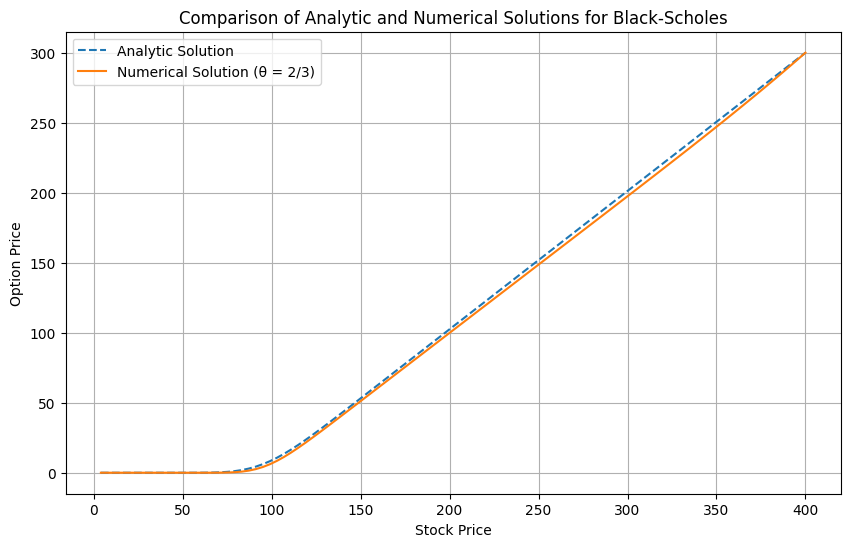

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf

# Parameters
S0 = 100  # Initial stock price
K = 100   # Strike price
T = 1.0   # Time to maturity
r = 0.05  # Risk-free rate
sigma = 0.2  # Volatility
N = 100  # Number of time steps
M = 100  # Number of stock price steps
S_max = 400  # Maximum stock price
dt = T / N  # Time step
ds = S_max / M  # Stock price step

# Grid (exclude S = 0 to avoid division by zero)
S = np.linspace(ds, S_max, M+1)  # Stock price grid
t = np.linspace(0, T, N+1)       # Time grid

# Analytic solution for European call option
def analytic_solution(S, K, r, sigma, t):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * (T - t)) / (sigma * np.sqrt(T - t + 1e-14))  # Avoid division by zero
    d2 = d1 - sigma * np.sqrt(T - t + 1e-14)
    call_price = S * 0.5 * (1 + erf(d1 / np.sqrt(2))) - K * np.exp(-r * (T - t)) * 0.5 * (1 + erf(d2 / np.sqrt(2)))
    return call_price

# Numerical scheme using fractional step theta method with theta = 1/3
def black_scholes_fractional_theta(S, K, r, sigma, t, dt, ds, M, N):
    theta = 2/3  # Fixed theta value
    V = np.zeros((M+1, N+1))  # Initialize the option price grid
    V[:, -1] = np.maximum(S - K, 0)  # Payoff at maturity (terminal condition)

    # Coefficients for the discretization
    alpha = 0.25 * sigma**2 * S**2 * dt / ds**2
    beta = 0.25 * r * S * dt / ds

    # Construct the tridiagonal matrices A and B
    A = np.zeros((M+1, M+1))
    B = np.zeros((M+1, M+1))

    for j in range(1, M):
        A[j, j-1] = -theta * (alpha[j] - beta[j])
        A[j, j] = 1 + theta * (2 * alpha[j] + r * dt)
        A[j, j+1] = -theta * (alpha[j] + beta[j])

        B[j, j-1] = (1 - theta) * (alpha[j] - beta[j])
        B[j, j] = 1 - (1 - theta) * (2 * alpha[j] + r * dt)
        B[j, j+1] = (1 - theta) * (alpha[j] + beta[j])

    # Boundary conditions
    A[0, 0] = 1
    A[M, M] = 1
    B[0, 0] = 1
    B[M, M] = 1

    # Time-stepping
    for i in range(N-1, -1, -1):
        V[:, i] = np.linalg.solve(A, B @ V[:, i+1])

    return V[:, 0]  # Return the numerical solution at t=0

# Compute solutions
analytic = analytic_solution(S, K, r, sigma, t)
numerical_solution = black_scholes_fractional_theta(S, K, r, sigma, t, dt, ds, M, N)

# Print the theta value used
print(f"Theta value used for the numerical solution: {2/3}")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(S, analytic, label='Analytic Solution', linestyle='--')
plt.plot(S, numerical_solution, label='Numerical Solution (θ = 2/3)')
plt.xlabel('Stock Price')
plt.ylabel('Option Price')
plt.title('Comparison of Analytic and Numerical Solutions for Black-Scholes')
plt.legend()
plt.grid(True)
plt.savefig('option_pricing_comparison_theta_1_3.png', dpi=300)
plt.show()

Fractional step theta

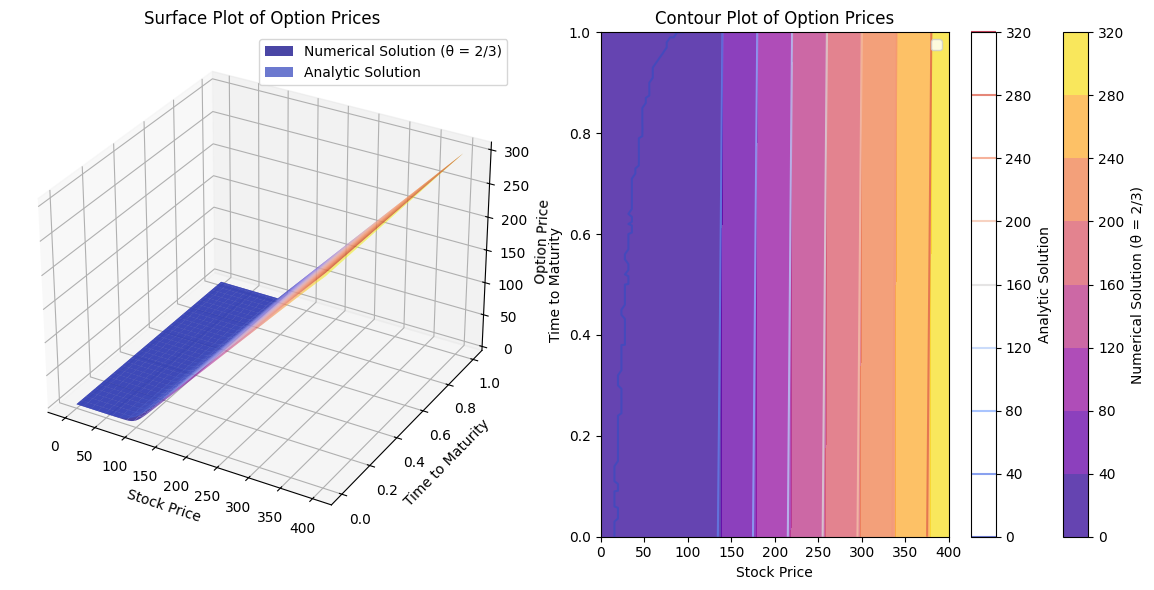

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
from mpl_toolkits.mplot3d import Axes3D

# Parameters
S0 = 100  # Initial stock price
K = 100   # Strike price
T = 1.0   # Time to maturity
r = 0.05  # Risk-free rate
sigma = 0.2  # Volatility
N = 100  # Number of time steps
M = 100  # Number of stock price steps
S_max = 400  # Maximum stock price
ds = S_max / M  # Stock price step

# CFL Condition for stability
dt = min(T / N, ds**2 / (sigma**2 * S_max**2))  # Time step ensuring stability

# Grid
S = np.linspace(0, S_max, M+1)
t = np.linspace(0, T, N+1)
S_grid, t_grid = np.meshgrid(S, t)

# Analytic solution for European call option
def analytic_solution(S, K, r, sigma, t):
    with np.errstate(divide='ignore', invalid='ignore'):  # Ignore division by zero
        d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * (T - t)) / (sigma * np.sqrt(T - t + 1e-14))  # Avoid division by zero
        d2 = d1 - sigma * np.sqrt(T - t + 1e-14)
        call_price = S * 0.5 * (1 + erf(d1 / np.sqrt(2))) - K * np.exp(-r * (T - t)) * 0.5 * (1 + erf(d2 / np.sqrt(2)))
        call_price[np.isnan(call_price)] = np.maximum(S[np.isnan(call_price)] - K, 0)  # Handle t = T case
    return call_price

# Numerical scheme using fractional step theta method (theta = 2/3)
def numerical_scheme(S, K, r, sigma, t, dt, ds, M, N):
    theta = 2/3  # Theta value
    V = np.zeros((M+1, N+1))
    V[:, -1] = np.maximum(S - K, 0)  # Terminal condition

    # Coefficients for the discretization
    alpha = 0.5 * sigma**2 * S**2 * dt / ds**2
    beta = 0.5 * r * S * dt / ds

    # Construct the tridiagonal matrices A and B
    A = np.zeros((M+1, M+1))
    B = np.zeros((M+1, M+1))

    for j in range(1, M):
        A[j, j-1] = -theta * (alpha[j] - beta[j])
        A[j, j] = 1 + theta * (2 * alpha[j] + r * dt)
        A[j, j+1] = -theta * (alpha[j] + beta[j])

        B[j, j-1] = (1 - theta) * (alpha[j] - beta[j])
        B[j, j] = 1 - (1 - theta) * (2 * alpha[j] + r * dt)
        B[j, j+1] = (1 - theta) * (alpha[j] + beta[j])

    # Boundary conditions
    A[0, 0] = 1
    A[M, M] = 1
    B[0, 0] = 1
    B[M, M] = 1

    # Time-stepping
    for j in range(N-1, -1, -1):
        V[:, j] = np.linalg.solve(A, B @ V[:, j+1])

    return V

# Compute solutions
analytic = np.zeros((M+1, N+1))
numerical = numerical_scheme(S, K, r, sigma, t, dt, ds, M, N)
for i in range(N+1):
    analytic[:, i] = analytic_solution(S, K, r, sigma, t[i])

# Surface Plot
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121, projection='3d')
surf1 = ax.plot_surface(S_grid, t_grid, numerical.T, cmap='plasma', alpha=0.75, label='Numerical Solution (θ = 2/3)')
surf2 = ax.plot_surface(S_grid, t_grid, analytic.T, cmap='coolwarm', alpha=0.75, label='Analytic Solution')
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Maturity')
ax.set_zlabel('Option Price')
ax.set_title('Surface Plot of Option Prices')
ax.legend()

# Contour Plot
ax2 = fig.add_subplot(122)
c1 = ax2.contourf(S_grid, t_grid, numerical.T, cmap='plasma', alpha=0.75)
c2 = ax2.contour(S_grid, t_grid, analytic.T, cmap='coolwarm', alpha=0.75)
plt.colorbar(c1, ax=ax2, label='Numerical Solution (θ = 2/3)')
plt.colorbar(c2, ax=ax2, label='Analytic Solution')
ax2.set_xlabel('Stock Price')
ax2.set_ylabel('Time to Maturity')
ax2.set_title('Contour Plot of Option Prices')
ax2.legend(['Numerical Solution (θ = 2/3)', 'Analytic Solution'])

plt.tight_layout()
plt.savefig('option_pricing_surface_contour_theta_2_3.png', dpi=300)
plt.show()

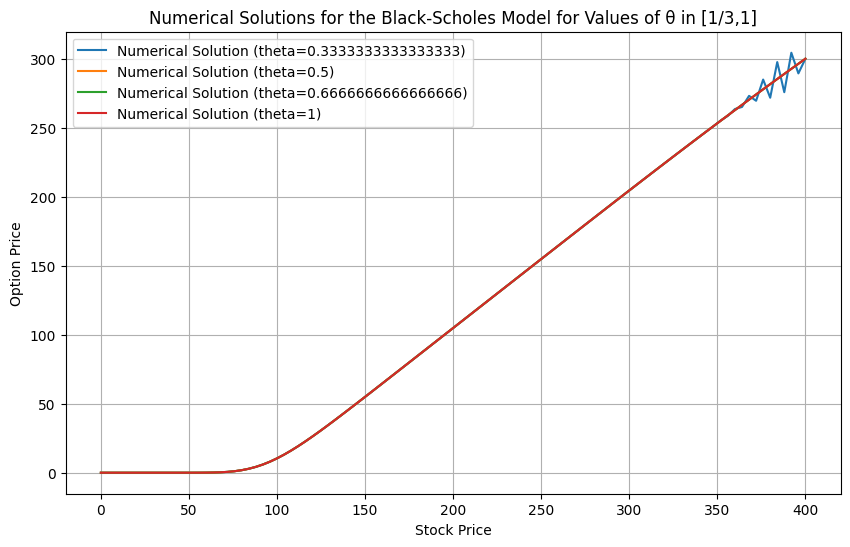

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
S0 = 100  # Initial stock price
K = 100   # Strike price
T = 1.0   # Time to maturity
r = 0.05  # Risk-free rate
sigma = 0.2  # Volatility
N = 100  # Number of time steps
M = 100  # Number of stock price steps
S_max = 400  # Maximum stock price
dt = T / N  # Time step
ds = S_max / M  # Stock price step

# Grid
S = np.linspace(0, S_max, M+1)
t = np.linspace(0, T, N+1)

# Numerical scheme using fractional step theta method with Crank-Nicolson in space
def black_scholes_fractional_theta(S, K, r, sigma, dt, ds, M, N, theta):
    V = np.zeros((M+1, N+1))  # Initialize the option price grid
    V[:, -1] = np.maximum(S - K, 0)  # Payoff at maturity (terminal condition)

    # Coefficients for the discretization
    alpha = 0.5 * sigma**2 * S**2 * dt / ds**2
    beta = 0.5 * r * S * dt / ds

    # Construct the tridiagonal matrices A and B
    A = np.zeros((M+1, M+1))
    B = np.zeros((M+1, M+1))

    for j in range(1, M):
        A[j, j-1] = -theta * (alpha[j] - beta[j])
        A[j, j] = 1 + theta * (2 * alpha[j] + r * dt)
        A[j, j+1] = -theta * (alpha[j] + beta[j])

        B[j, j-1] = (1 - theta) * (alpha[j] - beta[j])
        B[j, j] = 1 - (1 - theta) * (2 * alpha[j] + r * dt)
        B[j, j+1] = (1 - theta) * (alpha[j] + beta[j])

    # Boundary conditions
    A[0, 0] = 1
    A[M, M] = 1
    B[0, 0] = 1
    B[M, M] = 1

    # Time-stepping
    for i in range(N-1, -1, -1):
        V[:, i] = np.linalg.solve(A, B @ V[:, i+1])

    return V

# Theta values to use, excluding theta = 0
theta_values = [1/3, 1/2, 2/3, 1]

# Compute numerical solutions for each theta value
numerical_solutions = {theta: black_scholes_fractional_theta(S, K, r, sigma, dt, ds, M, N, theta) for theta in theta_values}

# Plot all numerical solutions in one plot
plt.figure(figsize=(10, 6))

for theta, solution in numerical_solutions.items():
    plt.plot(S, solution[:, 0], label=f'Numerical Solution (theta={theta})')

plt.xlabel('Stock Price')
plt.ylabel('Option Price')
plt.title('Numerical Solutions for the Black-Scholes Model for Values of θ in [1/3,1]')
plt.legend()
plt.grid(True)
plt.savefig('numerical_solutions_comparison_theta.png', dpi=300)
plt.show()


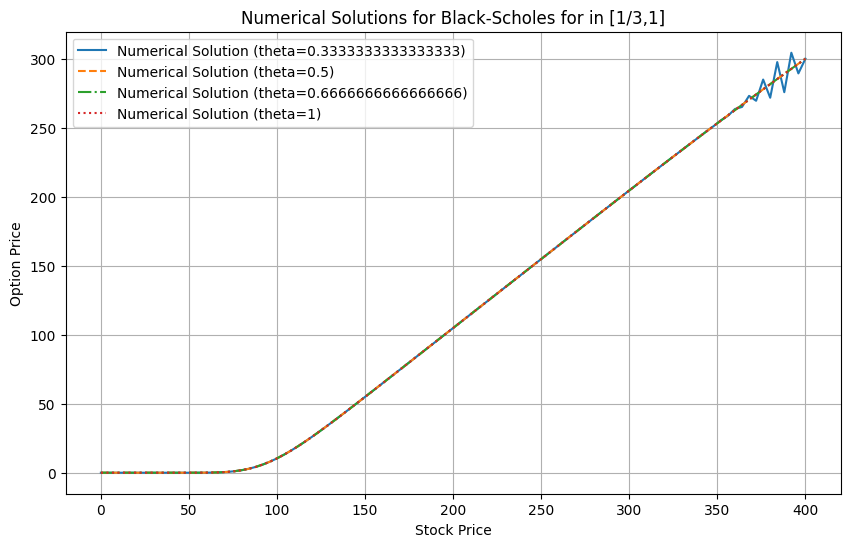

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
S0 = 100  # Initial stock price
K = 100   # Strike price
T = 1.0   # Time to maturity
r = 0.05  # Risk-free rate
sigma = 0.2  # Volatility
N = 100  # Number of time steps
M = 100  # Number of stock price steps
S_max = 400  # Maximum stock price
dt = T / N  # Time step
ds = S_max / M  # Stock price step

# Grid
S = np.linspace(0, S_max, M+1)
t = np.linspace(0, T, N+1)

# Numerical scheme using fractional step theta method with Crank-Nicolson in space
def black_scholes_fractional_theta(S, K, r, sigma, dt, ds, M, N, theta):
    V = np.zeros((M+1, N+1))  # Initialize the option price grid
    V[:, -1] = np.maximum(S - K, 0)  # Payoff at maturity (terminal condition)

    # Coefficients for the discretization
    alpha = 0.5 * sigma**2 * S**2 * dt / ds**2
    beta = 0.5 * r * S * dt / ds

    # Construct the tridiagonal matrices A and B
    A = np.zeros((M+1, M+1))
    B = np.zeros((M+1, M+1))

    for j in range(1, M):
        A[j, j-1] = -theta * (alpha[j] - beta[j])
        A[j, j] = 1 + theta * (2 * alpha[j] + r * dt)
        A[j, j+1] = -theta * (alpha[j] + beta[j])

        B[j, j-1] = (1 - theta) * (alpha[j] - beta[j])
        B[j, j] = 1 - (1 - theta) * (2 * alpha[j] + r * dt)
        B[j, j+1] = (1 - theta) * (alpha[j] + beta[j])

    # Boundary conditions
    A[0, 0] = 1
    A[M, M] = 1
    B[0, 0] = 1
    B[M, M] = 1

    # Time-stepping
    for i in range(N-1, -1, -1):
        V[:, i] = np.linalg.solve(A, B @ V[:, i+1])

    return V

# Theta values to use, excluding theta = 0
theta_values = [1/3, 1/2, 2/3, 1]
line_styles = ['-', '--', '-.', ':']

# Compute numerical solutions for each theta value
numerical_solutions = {theta: black_scholes_fractional_theta(S, K, r, sigma, dt, ds, M, N, theta) for theta in theta_values}

# Plot all numerical solutions in one plot with different line styles
plt.figure(figsize=(10, 6))

for theta, line_style in zip(theta_values, line_styles):
    solution = numerical_solutions[theta]
    plt.plot(S, solution[:, 0], label=f'Numerical Solution (theta={theta})', linestyle=line_style)

plt.xlabel('Stock Price')
plt.ylabel('Option Price')
plt.title('Numerical Solutions for Black-Scholes for in [1/3,1]')
plt.legend()
plt.grid(True)
plt.savefig('numerical_solutions_comparison_theta.png', dpi=300)
plt.show()


In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf

# Parameters
S0 = 100  # Initial stock price
K = 100   # Strike price
T = 1.0   # Time to maturity
r = 0.05  # Risk-free rate
sigma = 0.2  # Volatility
N = 100  # Number of time steps
M = 100  # Number of stock price steps
S_max = 400  # Maximum stock price
dt = T / N  # Time step
ds = S_max / M  # Stock price step

# Grid
S = np.linspace(0, S_max, M+1)
t = np.linspace(0, T, N+1)

# Analytic solution for European call option
def analytic_solution(S, K, r, sigma, t):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * (T - t)) / (sigma * np.sqrt(T - t))
    d2 = d1 - sigma * np.sqrt(T - t)
    call_price = S * 0.5 * (1 + erf(d1 / np.sqrt(2))) - K * np.exp(-r * (T - t)) * 0.5 * (1 + erf(d2 / np.sqrt(2)))
    return call_price

# Numerical scheme using fractional step theta method with Crank-Nicolson in space
def black_scholes_fractional_theta(S, K, r, sigma, dt, ds, M, N, theta):
    V = np.zeros((M+1, N+1))  # Initialize the option price grid
    V[:, -1] = np.maximum(S - K, 0)  # Payoff at maturity (terminal condition)

    # Coefficients for the discretization
    alpha = 0.5 * sigma**2 * S**2 * dt / ds**2
    beta = 0.5 * r * S * dt / ds

    # Construct the tridiagonal matrices A and B
    A = np.zeros((M+1, M+1))
    B = np.zeros((M+1, M+1))

    for j in range(1, M):
        A[j, j-1] = -theta * (alpha[j] - beta[j])
        A[j, j] = 1 + theta * (2 * alpha[j] + r * dt)
        A[j, j+1] = -theta * (alpha[j] + beta[j])

        B[j, j-1] = (1 - theta) * (alpha[j] - beta[j])
        B[j, j] = 1 - (1 - theta) * (2 * alpha[j] + r * dt)
        B[j, j+1] = (1 - theta) * (alpha[j] + beta[j])

    # Boundary conditions
    A[0, 0] = 1
    A[M, M] = 1
    B[0, 0] = 1
    B[M, M] = 1

    # Time-stepping
    for i in range(N-1, -1, -1):
        V[:, i] = np.linalg.solve(A, B @ V[:, i+1])

    return V

# Theta values to use
theta_values = [1/3, 1]

# Compute analytical solution
analytic = analytic_solution(S, K, r, sigma, t)

# Compute numerical solutions for each theta value
numerical_solutions = {theta: black_scholes_fractional_theta(S, K, r, sigma, dt, ds, M, N, theta) for theta in theta_values}

# Calculate errors and generate the table
errors = {}
for theta in theta_values:
    numerical = numerical_solutions[theta][:, 0]
    error = np.abs(analytic - numerical)
    errors[theta] = error

# Display the table of errors
import pandas as pd

df = pd.DataFrame({
    'Stock Price': S,
    'Analytical Solution': analytic,
    'Numerical Solution (theta=1/3)': numerical_solutions[1/3][:, 0],
    'Numerical Solution (theta=1)': numerical_solutions[1][:, 0],
    'Error (theta=1/3)': errors[1/3],
    'Error (theta=1)': errors[1]
})

# Display the DataFrame as a table
print(df.head())

# Optionally, save the DataFrame to a CSV file for further analysis
df.to_csv('errors_comparison.csv', index=False)

df.tail()


C:\Users\Admin\AppData\Local\Temp\ipykernel_24116\3049373371.py:23: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * (T - t)) / (sigma * np.sqrt(T - t))
C:\Users\Admin\AppData\Local\Temp\ipykernel_24116\3049373371.py:23: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * (T - t)) / (sigma * np.sqrt(T - t))


   Stock Price  Analytical Solution  Numerical Solution (theta=1/3)  \
0          0.0                  0.0                    0.000000e+00   
1          4.0                  0.0                    6.964828e-19   
2          8.0                  0.0                    3.228499e-16   
3         12.0                  0.0                    4.881061e-14   
4         16.0                  0.0                    3.545561e-12   

   Numerical Solution (theta=1)  Error (theta=1/3)  Error (theta=1)  
0                  0.000000e+00       0.000000e+00     0.000000e+00  
1                  6.130136e-18       6.964828e-19     6.130136e-18  
2                  2.186518e-15       3.228499e-16     2.186518e-15  
3                  2.578535e-13       4.881061e-14     2.578535e-13  
4                  1.483132e-11       3.545561e-12     1.483132e-11  


,Stock Price,Analytical Solution,Numerical Solution (theta=1/3),Numerical Solution (theta=1),Error (theta=1/3),Error (theta=1)
96,384.0,284.199800,297.581825,285.299295,13.382024,1.099495
97,388.0,288.149888,275.735472,288.998237,12.414415,0.848349
98,392.0,292.099950,304.356209,292.681423,12.256259,0.581473
99,396.0,296.049988,289.371870,296.348714,6.678117,0.298726
100,400.0,300.000000,300.000000,300.000000,0.000000,0.000000


+-------------------+---------------------+------------------------------------+---------------------+------------------------------------+-------------------+
|   Stock Price (S) |   Analytic Solution |   Error (theta=0.3333333333333333) |   Error (theta=0.5) |   Error (theta=0.6666666666666666) |   Error (theta=1) |
+===================+=====================+====================================+=====================+====================================+===================+
|          0.000000 |            0.000000 |                           0.000000 |            0.000000 |                           0.000000 |          0.000000 |
+-------------------+---------------------+------------------------------------+---------------------+------------------------------------+-------------------+
|          4.000000 |            0.000000 |                           0.000000 |            0.000000 |                           0.000000 |          0.000000 |
+-------------------+-------------------

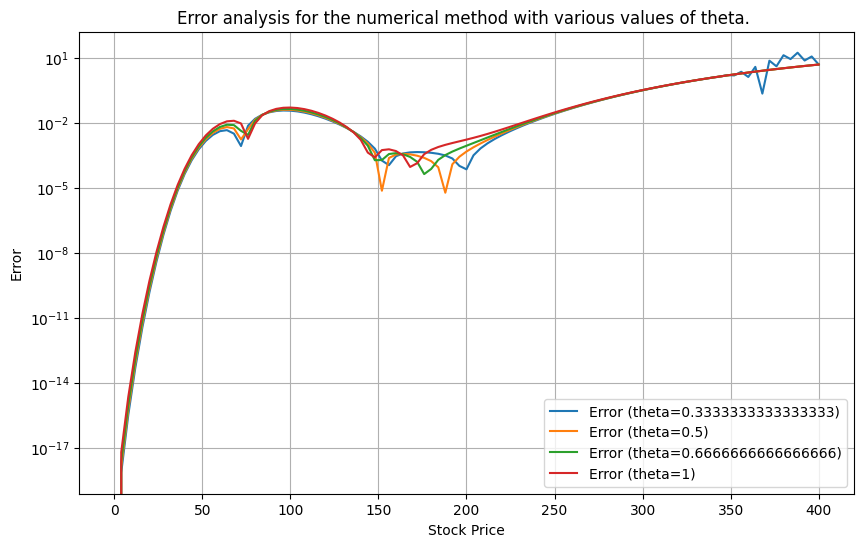

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
from tabulate import tabulate  # For printing tables

# Parameters
S0 = 100  # Initial stock price
K = 100   # Strike price
T = 1.0   # Time to maturity
r = 0.05  # Risk-free rate
sigma = 0.2  # Volatility
N = 100  # Number of time steps
M = 100  # Number of stock price steps
S_max = 400  # Maximum stock price
dt = T / N  # Time step
ds = S_max / M  # Stock price step

# Grid
S = np.linspace(0, S_max, M+1)
t = np.linspace(0, T, N+1)

# Analytic solution for European call option
def analytic_solution(S, K, r, sigma, t):
    with np.errstate(divide='ignore', invalid='ignore'):  # Ignore division by zero
        d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * (T - t)) / (sigma * np.sqrt(T - t + 1e-14))  # Avoid division by zero
        d2 = d1 - sigma * np.sqrt(T - t + 1e-14)
        call_price = S * 0.5 * (1 + erf(d1 / np.sqrt(2))) - K * np.exp(-r * (T - t)) * 0.5 * (1 + erf(d2 / np.sqrt(2)))
        call_price[np.isnan(call_price)] = np.maximum(S[np.isnan(call_price)] - K, 0)  # Handle t = T case
    return call_price

# Numerical scheme using fractional step theta method with Crank-Nicolson in space
def black_scholes_fractional_theta(S, K, r, sigma, dt, ds, M, N, theta):
    V = np.zeros((M+1, N+1))  # Initialize the option price grid
    V[:, -1] = np.maximum(S - K, 0)  # Payoff at maturity (terminal condition)

    # Coefficients for the discretization
    alpha = 0.5 * sigma**2 * S**2 * dt / ds**2
    beta = 0.5 * r * S * dt / ds

    # Construct the tridiagonal matrices A and B
    A = np.zeros((M+1, M+1))
    B = np.zeros((M+1, M+1))

    for j in range(1, M):
        A[j, j-1] = -theta * (alpha[j] - beta[j])
        A[j, j] = 1 + theta * (2 * alpha[j] + r * dt)
        A[j, j+1] = -theta * (alpha[j] + beta[j])

        B[j, j-1] = (1 - theta) * (alpha[j] - beta[j])
        B[j, j] = 1 - (1 - theta) * (2 * alpha[j] + r * dt)
        B[j, j+1] = (1 - theta) * (alpha[j] + beta[j])

    # Boundary conditions
    A[0, 0] = 1
    A[M, M] = 1
    B[0, 0] = 1
    B[M, M] = 1

    # Time-stepping
    for i in range(N-1, -1, -1):
        V[:, i] = np.linalg.solve(A, B @ V[:, i+1])

    return V

# Theta values to use
theta_values = [1/3, 0.5, 2/3, 1]  # Added theta = 0.5 and theta = 2/3

# Compute analytical solution at t = 0
analytic = analytic_solution(S, K, r, sigma, 0)  # Analytic solution at t = 0

# Compute numerical solutions for each theta value
numerical_solutions = {theta: black_scholes_fractional_theta(S, K, r, sigma, dt, ds, M, N, theta) for theta in theta_values}

# Calculate errors
errors = {}
for theta in theta_values:
    numerical = numerical_solutions[theta][:, 0]  # Numerical solution at t = 0
    error = np.abs(analytic - numerical)  # Absolute error
    errors[theta] = error

# Print a table of errors
table = []
for i in range(len(S)):
    row = [S[i], analytic[i]]
    for theta in theta_values:
        row.append(errors[theta][i])
    table.append(row)

# Print the table
headers = ["Stock Price (S)", "Analytic Solution"] + [f"Error (theta={theta})" for theta in theta_values]
print(tabulate(table, headers=headers, tablefmt="grid", floatfmt=".6f"))

# Plot errors as a function of stock prices
plt.figure(figsize=(10, 6))

# Plot errors for each theta value
for theta in theta_values:
    plt.plot(S, errors[theta], label=f'Error (theta={theta})', linestyle='-')

plt.xlabel('Stock Price')
plt.ylabel('Error')
plt.title('Error analysis for the numerical method with various values of theta. ')
plt.legend()
plt.grid(True)
plt.yscale('log')  # Use logarithmic scale for y-axis to show small errors
plt.savefig('errors_comparison_theta.png', dpi=300)
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_24116\3911980462.py:80: RuntimeWarning: divide by zero encountered in divide
  relative_error = error / np.abs(analytic)  # Relative error
C:\Users\Admin\AppData\Local\Temp\ipykernel_24116\3911980462.py:80: RuntimeWarning: invalid value encountered in divide
  relative_error = error / np.abs(analytic)  # Relative error


+-------------------+---------------------+---------------------------------------------+---------------------------------------------+------------------------------+------------------------------+---------------------------------------------+---------------------------------------------+----------------------------+----------------------------+
|   Stock Price (S) |   Analytic Solution |   Absolute Error (theta=0.3333333333333333) |   Relative Error (theta=0.3333333333333333) |   Absolute Error (theta=0.5) |   Relative Error (theta=0.5) |   Absolute Error (theta=0.6666666666666666) |   Relative Error (theta=0.6666666666666666) |   Absolute Error (theta=1) |   Relative Error (theta=1) |
+===================+=====================+=============================================+=============================================+==============================+==============================+=============================================+=============================================+===============

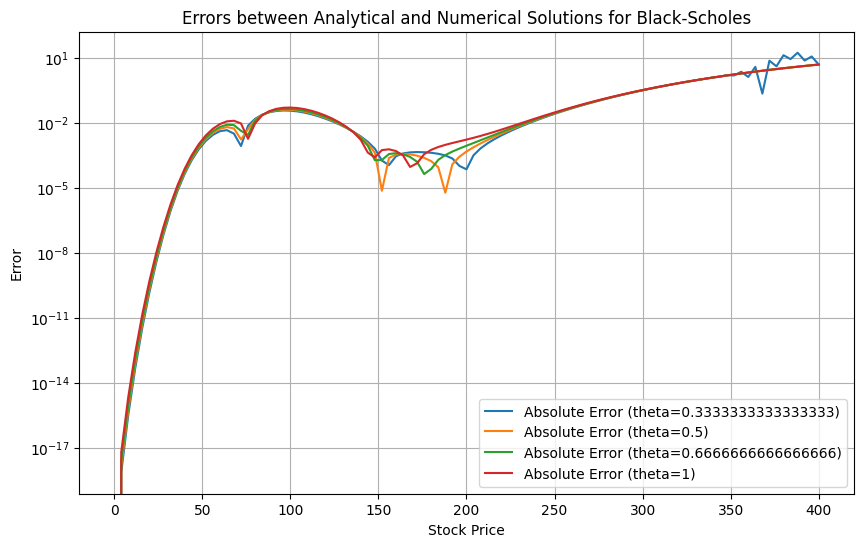

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
from tabulate import tabulate  # For printing tables

# Parameters
S0 = 100  # Initial stock price
K = 100   # Strike price
T = 1.0   # Time to maturity
r = 0.05  # Risk-free rate
sigma = 0.2  # Volatility
N = 100  # Number of time steps
M = 100  # Number of stock price steps
S_max = 400  # Maximum stock price
dt = T / N  # Time step
ds = S_max / M  # Stock price step

# Grid
S = np.linspace(0, S_max, M+1)
t = np.linspace(0, T, N+1)

# Analytic solution for European call option
def analytic_solution(S, K, r, sigma, t):
    with np.errstate(divide='ignore', invalid='ignore'):  # Ignore division by zero
        d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * (T - t)) / (sigma * np.sqrt(T - t + 1e-14))  # Avoid division by zero
        d2 = d1 - sigma * np.sqrt(T - t + 1e-14)
        call_price = S * 0.5 * (1 + erf(d1 / np.sqrt(2))) - K * np.exp(-r * (T - t)) * 0.5 * (1 + erf(d2 / np.sqrt(2)))
        call_price[np.isnan(call_price)] = np.maximum(S[np.isnan(call_price)] - K, 0)  # Handle t = T case
    return call_price

# Numerical scheme using fractional step theta method with Crank-Nicolson in space
def black_scholes_fractional_theta(S, K, r, sigma, dt, ds, M, N, theta):
    V = np.zeros((M+1, N+1))  # Initialize the option price grid
    V[:, -1] = np.maximum(S - K, 0)  # Payoff at maturity (terminal condition)

    # Coefficients for the discretization
    alpha = 0.5 * sigma**2 * S**2 * dt / ds**2
    beta = 0.5 * r * S * dt / ds

    # Construct the tridiagonal matrices A and B
    A = np.zeros((M+1, M+1))
    B = np.zeros((M+1, M+1))

    for j in range(1, M):
        A[j, j-1] = -theta * (alpha[j] - beta[j])
        A[j, j] = 1 + theta * (2 * alpha[j] + r * dt)
        A[j, j+1] = -theta * (alpha[j] + beta[j])

        B[j, j-1] = (1 - theta) * (alpha[j] - beta[j])
        B[j, j] = 1 - (1 - theta) * (2 * alpha[j] + r * dt)
        B[j, j+1] = (1 - theta) * (alpha[j] + beta[j])

    # Boundary conditions
    A[0, 0] = 1
    A[M, M] = 1
    B[0, 0] = 1
    B[M, M] = 1

    # Time-stepping
    for i in range(N-1, -1, -1):
        V[:, i] = np.linalg.solve(A, B @ V[:, i+1])

    return V

# Theta values to use
theta_values = [1/3, 0.5, 2/3, 1]  # Added theta = 0.5 and theta = 2/3

# Compute analytical solution at t = 0
analytic = analytic_solution(S, K, r, sigma, 0)  # Analytic solution at t = 0

# Compute numerical solutions for each theta value
numerical_solutions = {theta: black_scholes_fractional_theta(S, K, r, sigma, dt, ds, M, N, theta) for theta in theta_values}

# Calculate errors
errors = {}
relative_errors = {}
for theta in theta_values:
    numerical = numerical_solutions[theta][:, 0]  # Numerical solution at t = 0
    error = np.abs(analytic - numerical)  # Absolute error
    relative_error = error / np.abs(analytic)  # Relative error
    errors[theta] = error
    relative_errors[theta] = relative_error

# Print a table of errors
table = []
for i in range(len(S)):
    row = [S[i], analytic[i]]
    for theta in theta_values:
        row.append(errors[theta][i])
        row.append(relative_errors[theta][i])
    table.append(row)

# Print the table
headers = ["Stock Price (S)", "Analytic Solution"]
for theta in theta_values:
    headers.append(f"Absolute Error (theta={theta})")
    headers.append(f"Relative Error (theta={theta})")

print(tabulate(table, headers=headers, tablefmt="grid", floatfmt=".6f"))

# Plot errors as a function of stock prices
plt.figure(figsize=(10, 6))

# Plot errors for each theta value
for theta in theta_values:
    plt.plot(S, errors[theta], label=f'Absolute Error (theta={theta})', linestyle='-')

plt.xlabel('Stock Price')
plt.ylabel('Error')
plt.title('Errors between Analytical and Numerical Solutions for Black-Scholes')
plt.legend()
plt.grid(True)
plt.yscale('log')  # Use logarithmic scale for y-axis to show small errors
plt.savefig('errors_comparison_theta.png', dpi=300)
plt.show()

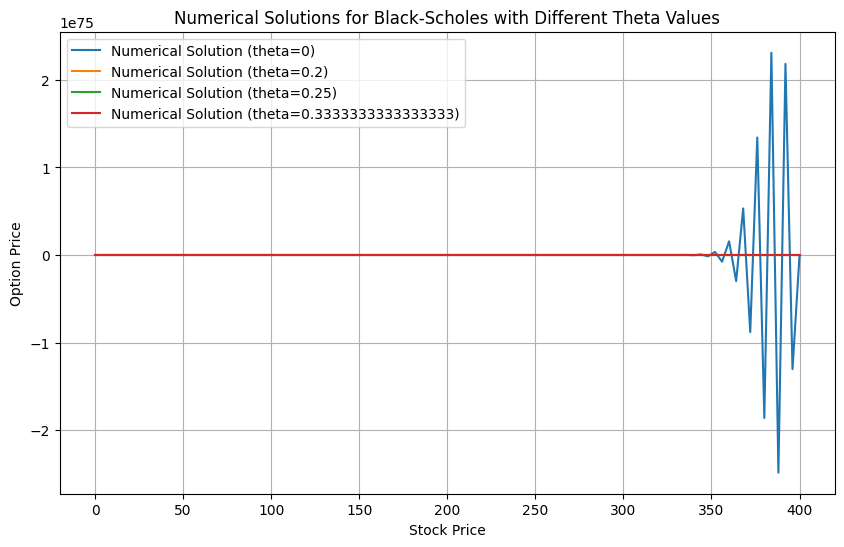

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
S0 = 100  # Initial stock price
K = 100   # Strike price
T = 1.0   # Time to maturity
r = 0.05  # Risk-free rate
sigma = 0.2  # Volatility
N = 100  # Number of time steps
M = 100  # Number of stock price steps
S_max = 400  # Maximum stock price
dt = T / N  # Time step
ds = S_max / M  # Stock price step

# Grid
S = np.linspace(0, S_max, M+1)
t = np.linspace(0, T, N+1)

# Numerical scheme using fractional step theta method with Crank-Nicolson in space
def black_scholes_fractional_theta(S, K, r, sigma, dt, ds, M, N, theta):
    V = np.zeros((M+1, N+1))  # Initialize the option price grid
    V[:, -1] = np.maximum(S - K, 0)  # Payoff at maturity (terminal condition)

    # Coefficients for the discretization
    alpha = 0.5 * sigma**2 * S**2 * dt / ds**2
    beta = 0.5 * r * S * dt / ds

    # Construct the tridiagonal matrices A and B
    A = np.zeros((M+1, M+1))
    B = np.zeros((M+1, M+1))

    for j in range(1, M):
        A[j, j-1] = -theta * (alpha[j] - beta[j])
        A[j, j] = 1 + theta * (2 * alpha[j] + r * dt)
        A[j, j+1] = -theta * (alpha[j] + beta[j])

        B[j, j-1] = (1 - theta) * (alpha[j] - beta[j])
        B[j, j] = 1 - (1 - theta) * (2 * alpha[j] + r * dt)
        B[j, j+1] = (1 - theta) * (alpha[j] + beta[j])

    # Boundary conditions
    A[0, 0] = 1
    A[M, M] = 1
    B[0, 0] = 1
    B[M, M] = 1

    # Time-stepping
    for i in range(N-1, -1, -1):
        V[:, i] = np.linalg.solve(A, B @ V[:, i+1])

    return V

# Theta values to use
theta_values = [0, 1/5,1/4, 1/3]

# Compute numerical solutions for each theta value
numerical_solutions = {}
for theta in theta_values:
    numerical_solutions[theta] = black_scholes_fractional_theta(S, K, r, sigma, dt, ds, M, N, theta)

# Plot numerical solutions
plt.figure(figsize=(10, 6))
for theta in theta_values:
    plt.plot(S, numerical_solutions[theta][:, 0], label=f'Numerical Solution (theta={theta})')

plt.xlabel('Stock Price')
plt.ylabel('Option Price')
plt.title('Numerical Solutions for Black-Scholes with Different Theta Values')
plt.legend()
plt.grid(True)
plt.savefig('numerical_solutions_theta_comparison.png', dpi=300)
plt.show()

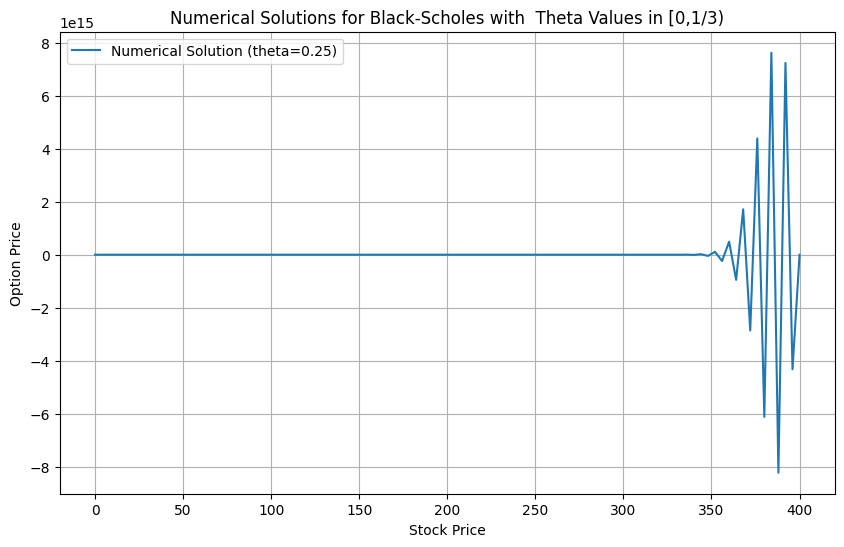

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
S0 = 100  # Initial stock price
K = 100   # Strike price
T = 1.0   # Time to maturity
r = 0.05  # Risk-free rate
sigma = 0.2  # Volatility
N = 100  # Number of time steps
M = 100  # Number of stock price steps
S_max = 400  # Maximum stock price
dt = T / N  # Time step
ds = S_max / M  # Stock price step

# Grid
S = np.linspace(0, S_max, M+1)
t = np.linspace(0, T, N+1)

# Numerical scheme using fractional step theta method with Crank-Nicolson in space
def black_scholes_fractional_theta(S, K, r, sigma, dt, ds, M, N, theta):
    V = np.zeros((M+1, N+1))  # Initialize the option price grid
    V[:, -1] = np.maximum(S - K, 0)  # Payoff at maturity (terminal condition)

    # Coefficients for the discretization
    alpha = 0.5 * sigma**2 * S**2 * dt / ds**2
    beta = 0.5 * r * S * dt / ds

    # Construct the tridiagonal matrices A and B
    A = np.zeros((M+1, M+1))
    B = np.zeros((M+1, M+1))

    for j in range(1, M):
        A[j, j-1] = -theta * (alpha[j] - beta[j])
        A[j, j] = 1 + theta * (2 * alpha[j] + r * dt)
        A[j, j+1] = -theta * (alpha[j] + beta[j])

        B[j, j-1] = (1 - theta) * (alpha[j] - beta[j])
        B[j, j] = 1 - (1 - theta) * (2 * alpha[j] + r * dt)
        B[j, j+1] = (1 - theta) * (alpha[j] + beta[j])

    # Boundary conditions
    A[0, 0] = 1
    A[M, M] = 1
    B[0, 0] = 1
    B[M, M] = 1

    # Time-stepping
    for i in range(N-1, -1, -1):
        V[:, i] = np.linalg.solve(A, B @ V[:, i+1])

    return V

# Theta values to use
theta_values = [ 0.25]

# Compute numerical solutions for each theta value
numerical_solutions = {}
for theta in theta_values:
    numerical_solutions[theta] = black_scholes_fractional_theta(S, K, r, sigma, dt, ds, M, N, theta)

# Plot numerical solutions
plt.figure(figsize=(10, 6))
for theta in theta_values:
    plt.plot(S, numerical_solutions[theta][:, 0], label=f'Numerical Solution (theta={theta})')

plt.xlabel('Stock Price')
plt.ylabel('Option Price')
plt.title('Numerical Solutions for Black-Scholes with  Theta Values in [0,1/3)')
plt.legend()
plt.grid(True)
plt.savefig('numerical_solutions_theta_comparison.png', dpi=300)
plt.show()

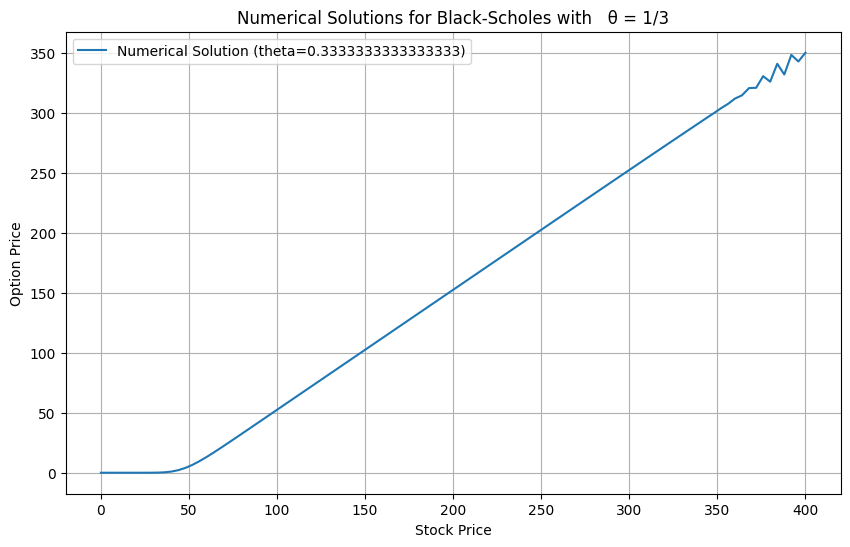

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
S0 = 100  # Initial stock price
K = 50   # Strike price
T = 1.0   # Time to maturity
r = 0.05  # Risk-free rate
sigma = 0.2  # Volatility
N = 100  # Number of time steps
M = 100  # Number of stock price steps
S_max = 400  # Maximum stock price
dt = T / N  # Time step
ds = S_max / M  # Stock price step

# Grid
S = np.linspace(0, S_max, M+1)
t = np.linspace(0, T, N+1)

# Numerical scheme using fractional step theta method with Crank-Nicolson in space
def black_scholes_fractional_theta(S, K, r, sigma, dt, ds, M, N, theta):
    V = np.zeros((M+1, N+1))  # Initialize the option price grid
    V[:, -1] = np.maximum(S - K, 0)  # Payoff at maturity (terminal condition)

    # Coefficients for the discretization
    alpha = 0.5 * sigma**2 * S**2 * dt / ds**2
    beta = 0.5 * r * S * dt / ds

    # Construct the tridiagonal matrices A and B
    A = np.zeros((M+1, M+1))
    B = np.zeros((M+1, M+1))

    for j in range(1, M):
        A[j, j-1] = -theta * (alpha[j] - beta[j])
        A[j, j] = 1 + theta * (2 * alpha[j] + r * dt)
        A[j, j+1] = -theta * (alpha[j] + beta[j])

        B[j, j-1] = (1 - theta) * (alpha[j] - beta[j])
        B[j, j] = 1 - (1 - theta) * (2 * alpha[j] + r * dt)
        B[j, j+1] = (1 - theta) * (alpha[j] + beta[j])

    # Boundary conditions
    A[0, 0] = 1
    A[M, M] = 1
    B[0, 0] = 1
    B[M, M] = 1

    # Time-stepping
    for i in range(N-1, -1, -1):
        V[:, i] = np.linalg.solve(A, B @ V[:, i+1])

    return V

# Theta values to use
theta_values = [ 1/3]

# Compute numerical solutions for each theta value
numerical_solutions = {}
for theta in theta_values:
    numerical_solutions[theta] = black_scholes_fractional_theta(S, K, r, sigma, dt, ds, M, N, theta)

# Plot numerical solutions
plt.figure(figsize=(10, 6))
for theta in theta_values:
    plt.plot(S, numerical_solutions[theta][:, 0], label=f'Numerical Solution (theta={theta})')

plt.xlabel('Stock Price')
plt.ylabel('Option Price')
plt.title('Numerical Solutions for Black-Scholes with   θ = 1/3')
plt.legend()
plt.grid(True)
plt.savefig('numerical_solutions_theta_comparison.png', dpi=300)
plt.show()